In [1]:
import xml.etree.ElementTree as ET
import matplotlib as plt
import pandas as pd
import numpy as np
import trec
import pprint as pp

# https://wiki.python.org/moin/UsingPickle
import pickle

Queries = "data/topics-2014_2015-summary.topics"
Qrels = "data/qrels-clinical_trials.txt"
with open(Queries, 'r') as queries_reader:
    txt = queries_reader.read()

root = ET.fromstring(txt)

cases = {}
for query in root.iter('TOP'):
    q_num = query.find('NUM').text
    q_title = query.find('TITLE').text
    cases[q_num] = q_title

eval = trec.TrecEvaluation(cases, Qrels)

# pp.pprint(cases)


In [2]:
import xml.etree.ElementTree as ET
import tarfile

tar = tarfile.open("data/clinicaltrials.gov-16_dec_2015.tgz", "r:gz")
i = 0
ids = []
docs = []
docs_detailed_desc = [None] * 3626
brief_summary_docs = [None] * 3626
criteria_docs = [None] * 3626
for tarinfo in tar:
    if tarinfo.size > 500:
        txt = tar.extractfile(tarinfo).read().decode("utf-8", "strict")
        root = ET.fromstring(txt)

        judged = False
        for doc_id in root.iter('nct_id'):
            if doc_id.text in eval.judged_docs:
                judged = True

        if judged is False:
            continue


        for brief_title in root.iter('brief_title'):
            #print("brief_title: ", brief_title.text)
            docs.append(brief_title.text)
            ids.append(doc_id.text)

        for detailed_description in root.iter('detailed_description'):
            for child in detailed_description:
                #print("detailed_description: ", child.text.strip())
                docs_detailed_desc[i] = child.text.strip()
                
        for brief_summary in root.iter('brief_summary'):
            for child in brief_summary:
                #print("brief_summary: ", child.text.strip())
                brief_summary_docs[i] = child.text.strip()
                
        for criteria in root.iter('criteria'):
            for child in criteria:
                criteria_docs[i] = child.text.strip()
                
        i += 1

tar.close()

for index, doc in enumerate(brief_summary_docs):
    if(doc == None):
        brief_summary_docs[index] = docs[index]

for index, doc in enumerate(docs_detailed_desc):
    if(doc == None):
        docs_detailed_desc[index] = brief_summary_docs[index]
        
for index, doc in enumerate(criteria_docs):
    if(doc == None):
        criteria_docs[index] = docs_detailed_desc[index]

print(i)
pickle.dump(docs, open( "documents.bin", "wb" ) )
pickle.dump(ids, open( "doc_ids.bin", "wb" ) )
pickle.dump(docs_detailed_desc, open( "documents_detailed_description.bin", "wb" ) )
pickle.dump(brief_summary_docs, open( "brief_summary_docs.bin", "wb" ))
pickle.dump(criteria_docs, open( "criteria_docs.bin", "wb" ))

3626


# DIVIDING

In [3]:
from itertools import islice
import random
seed = random.seed(42)
cases_keys = list(cases.keys())
random.shuffle(cases_keys)
cases2 = {}
for key in cases_keys:
    cases2[key] = cases[key]
inc = iter(cases2.items())
test = dict(islice((inc), len(cases) // 5))
train = dict(inc)

# Whole set

In [66]:
import pickle
docs = pickle.load( open( "documents.bin", "rb" ) )
ids = pickle.load( open( "doc_ids.bin", "rb" ) )

from sklearn.metrics.pairwise import pairwise_distances
from sklearn.feature_extraction.text import TfidfVectorizer

index = TfidfVectorizer(ngram_range=(1,1), analyzer='word', stop_words = None)
index.fit(docs)

# Compute the corpus representation
X = index.transform(docs)


In [5]:
avg_precision_11point = np.zeros(11)
for caseid in cases:
    query = cases[caseid]
    query_tfidf = index.transform([query])

    doc_scores = 1 - pairwise_distances(X, query_tfidf, metric='cosine')
    
    results = pd.DataFrame(list(zip(ids, doc_scores)), columns = ['_id', 'score'])
    results_ord = results.sort_values(by=['score'], ascending = False)
    
    [p10, recall, ap, ndcg5, mrr] = eval.eval(results_ord, caseid)
    [precision_11point, recall_11point, total_relv_ret] = eval.evalPR(results_ord, caseid)

    if (np.shape(recall_11point) != (0,)):
        avg_precision_11point = avg_precision_11point + precision_11point

    print(ap)


0.019001940397946095
0.060866353856246655
0.08767466292220252
0.017877701784794565
0.031694224664332776
0.057008884176519094
0.33709176703214544
0.007653088814735288
0.0076984359443049806
0.056127644422433204
0.0032595854680093515
0.11272509465854778
0.032192396318795974
0.0041343265980410895
0.060625620196764075
0.00603928841989503
0.23763853106232868
0.02655710908449622
0.038120384343823255
0.01618800201356972
0.02563343862516546
0.014170047114818214
0.023016996165551588
0.05917273499939565
0.002473294862243666
0.07312271062271061
0.06645980041279621
0
0.07454644121759396
0.035169379615586104
0.00802516889686075
0.00504200503522685
0.010251334026484057
0.008606628786405108
0.007704855898634977
0.04001101350775705
0.0108143183952977
0.05685354742159221
0.05
0.02366940040674103
0.004346116514238688
0.00794598793931938
0.001701628252323889
0.07112392723234046
0.09781636467693455
0.007472707432031623
0.08233788979066337
0.02820479539734805
0.051422747981683406
0.00751044586769651
0.02805

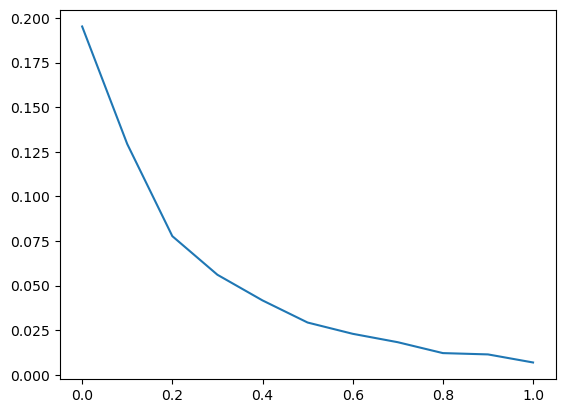

In [ ]:
import matplotlib.pyplot as plt
plt.plot(recall_11point,avg_precision_11point/len(cases))


# TRAINING

In [155]:
from statistics import mean

class Vsm:
    def fit(self, ids, tfidf_wm, data):
        self.Queries = "topics-2014_2015-summary.topics"
        self.Qrels = "qrels-clinical_trials.txt"
        self.eval = trec.TrecEvaluation(data, Qrels)
        self.p10_p = []
        self.recall_p = []
        self.ap_p = []
        self.ndcg5_p = []
        self.mrr_p = []
        self.avg_precision_11point = np.zeros(11)
        self.recall_11point = 0
        self.score_set = []
        for caseid in data:
            query = data[caseid]
            query_tfidf = index.transform([query])

            doc_scores = 1 - pairwise_distances(tfidf_wm, query_tfidf, metric='cosine')

            results = pd.DataFrame(list(zip(np.array(ids), doc_scores)), columns = ['_id', 'score'])
            results_ord = results.sort_values(by=['score'], ascending = False)

            [p10, recall, ap, ndcg5, mrr] = eval.eval(results_ord, caseid)
            [precision_11point, self.recall_11point, total_relv_ret] = eval.evalPR(results_ord, caseid)

            if (np.shape(self.recall_11point) != (0,)):
                self.avg_precision_11point = self.avg_precision_11point + precision_11point

            self.p10_p.append(p10)
            self.recall_p.append(recall)
            self.ap_p.append(ap)
            self.ndcg5_p.append(ndcg5)
            self.mrr_p.append(mrr)
            
            for i, j in results.to_numpy():
                self.score_set.append((caseid, i, j[0]))
                
    def show_results(self):
        print ("Mean of p10: ", np.mean(self.p10_p),"\nMean of recall: ", np.mean(self.recall_p), "\nMean of ap_p: ", np.mean(self.ap_p), "\nMean of ndcg5_p: ", np.mean(self.ndcg5_p),"\nMean of mrr_p: ", np.mean(self.mrr_p))
        print (max(self.p10_p), max(self.recall_p), max(self.ap_p), max(self.ndcg5_p), max(self.mrr_p))
        print (min(self.p10_p), min(self.recall_p), min(self.ap_p), min(self.ndcg5_p), min(self.mrr_p))


In [156]:
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.feature_extraction.text import TfidfVectorizer
import pickle

docs = pickle.load( open( "documents.bin", "rb" ) )
ids = pickle.load( open( "doc_ids.bin", "rb" ) )
docs_detailed_desc = pickle.load(open("documents_detailed_description.bin", "rb"))
brief_summary_docs = pickle.load(open("brief_summary_docs.bin", "rb"))
criteria_docs = pickle.load(open("criteria_docs.bin", "rb"))

index = TfidfVectorizer(ngram_range=(1,1), analyzer='word', stop_words = None)


In [157]:
#docs
tfidf_wm_docs_train = index.fit_transform(docs)
vsm_docs_train = Vsm()
vsm_docs_train.fit(ids, tfidf_wm_docs_train, train)
vsm_docs_train.show_results()

Mean of p10:  0.060416666666666674 
Mean of recall:  0.9791666666666666 
Mean of ap_p:  0.03560801774813862 
Mean of ndcg5_p:  0.048257370620261954 
Mean of mrr_p:  0.00520546056260342
0.5 1.0 0.33709176703214544 0.3391602052736161 0.017374517374517374
0.0 0 0 0.0 0


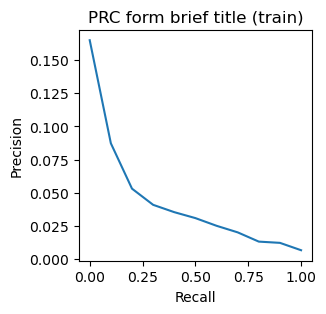

In [164]:
fig, ax = plt.subplots(figsize=(3, 3))
plt.plot(vsm_docs_train.recall_11point,vsm_docs_train.avg_precision_11point/len(train))
ax.set_title("PRC form brief title (train)")
ax.set_ylabel("Precision")
ax.set_xlabel("Recall")
plt.show()

In [165]:
#VSM docs detailed
tfidf_wm_detail_train = index.fit_transform(docs_detailed_desc)
vsm_detail_train = Vsm()
vsm_detail_train.fit(ids, tfidf_wm_detail_train, train)
vsm_detail_train.show_results()

Mean of p10:  0.11666666666666668 
Mean of recall:  0.9791666666666666 
Mean of ap_p:  0.07803368525241139 
Mean of ndcg5_p:  0.10912767778142507 
Mean of mrr_p:  0.00520546056260342
0.3 1.0 0.4290594305062977 0.5531464700081437 0.017374517374517374
0.0 0 0 0.0 0


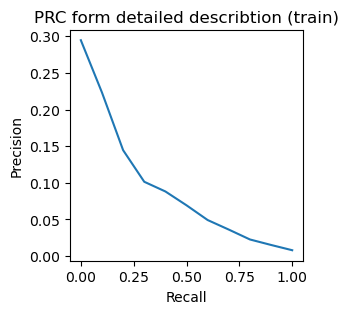

In [166]:
fig, ax = plt.subplots(figsize=(3, 3))
plt.plot(vsm_detail_train.recall_11point,vsm_detail_train.avg_precision_11point/len(train))
ax.set_title("PRC form detailed describtion (train)")
ax.set_ylabel("Precision")
ax.set_xlabel("Recall")
plt.show()

In [167]:
#criteria
tfidf_wm_citeria_train = index.fit_transform(criteria_docs)
vsm_criteria_train = Vsm()
vsm_criteria_train.fit(ids, tfidf_wm_citeria_train, train)
vsm_criteria_train.show_results()

Mean of p10:  0.09166666666666667 
Mean of recall:  0.9791666666666666 
Mean of ap_p:  0.05543059902788689 
Mean of ndcg5_p:  0.09398049573467478 
Mean of mrr_p:  0.00520546056260342
0.6 1.0 0.22921753864308655 0.8539316501572937 0.017374517374517374
0.0 0 0 0.0 0


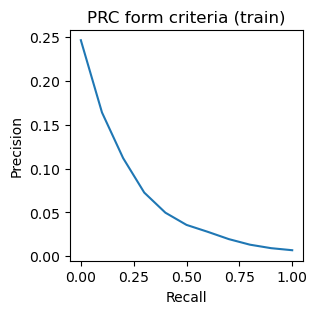

In [168]:
fig, ax = plt.subplots(figsize=(3, 3))
plt.plot(vsm_criteria_train.recall_11point,vsm_criteria_train.avg_precision_11point/len(train))
ax.set_title("PRC form criteria (train)")
ax.set_ylabel("Precision")
ax.set_xlabel("Recall")
plt.show()

In [169]:
#summary
tfidf_wm_summary_train = index.fit_transform(brief_summary_docs)
vsm_summ_train = Vsm()
vsm_summ_train.fit(ids, tfidf_wm_summary_train, train)
vsm_summ_train.show_results()

Mean of p10:  0.08958333333333335 
Mean of recall:  0.9791666666666666 
Mean of ap_p:  0.06741128876167297 
Mean of ndcg5_p:  0.09591045889794651 
Mean of mrr_p:  0.00520546056260342
0.4 1.0 0.36629685942298534 0.48522855511632257 0.017374517374517374
0.0 0 0 0.0 0


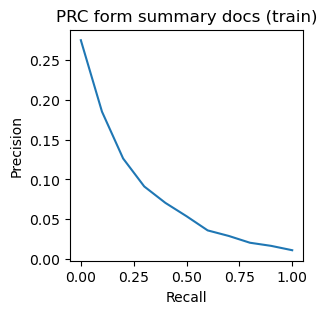

In [170]:
fig, ax = plt.subplots(figsize=(3, 3))
plt.plot(vsm_summ_train.recall_11point,vsm_summ_train.avg_precision_11point/len(train))
ax.set_title("PRC form summary docs (train)")
ax.set_ylabel("Precision")
ax.set_xlabel("Recall")
plt.show()

# TESTING

In [171]:
#docs
tfidf_wm_docs_test = index.transform(docs)
vsm_docs_test = Vsm()
vsm_docs_test.fit(ids, tfidf_wm_docs_test, test)
vsm_docs_test.show_results()

Mean of p10:  0.11666666666666665 
Mean of recall:  1.0 
Mean of ap_p:  0.08652396042566791 
Mean of ndcg5_p:  0.14106528397301293 
Mean of mrr_p:  0.00459643316786174
0.5 1.0 0.3191049408832995 0.4785372057762079 0.018753447324875896
0.0 1.0 0.0037832422360117384 0.0 0.0002757859900717044


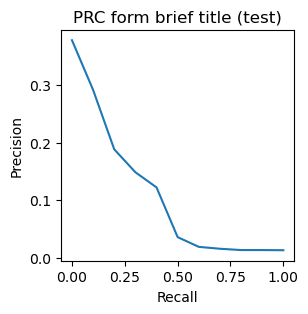

In [172]:
fig, ax = plt.subplots(figsize=(3, 3))
plt.plot(vsm_docs_test.recall_11point,vsm_docs_test.avg_precision_11point/len(test))
ax.set_title("PRC form brief title (test)")
ax.set_ylabel("Precision")
ax.set_xlabel("Recall")
plt.show()

In [174]:
#VSM docs detailed
tfidf_wm_detail_test = index.transform(docs_detailed_desc)
vsm_detail_test = Vsm()
vsm_detail_test.fit(ids, tfidf_wm_detail_test, test)
vsm_detail_test.show_results()

Mean of p10:  0.08333333333333333 
Mean of recall:  1.0 
Mean of ap_p:  0.07280665704094792 
Mean of ndcg5_p:  0.08315824933487959 
Mean of mrr_p:  0.00459643316786174
0.3 1.0 0.2101011754389147 0.30078518014914984 0.018753447324875896
0.0 1.0 0.003303111292071592 0.0 0.0002757859900717044


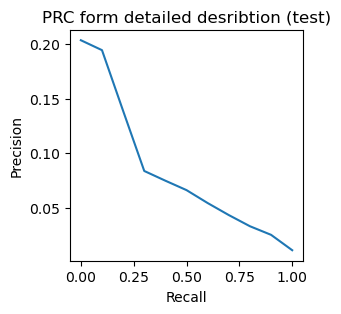

In [175]:
fig, ax = plt.subplots(figsize=(3, 3))
plt.plot(vsm_detail_test.recall_11point,vsm_detail_test.avg_precision_11point/len(test))
ax.set_title("PRC form detailed desribtion (test)")
ax.set_ylabel("Precision")
ax.set_xlabel("Recall")
plt.show()

In [176]:
#criteria
tfidf_wm_citeria_test = index.transform(criteria_docs)
vsm_criteria_test = Vsm()
vsm_criteria_test.fit(ids, tfidf_wm_citeria_test, test)
vsm_criteria_test.show_results()

Mean of p10:  0.14166666666666666 
Mean of recall:  1.0 
Mean of ap_p:  0.10693002104237039 
Mean of ndcg5_p:  0.18369652229389014 
Mean of mrr_p:  0.00459643316786174
0.4 1.0 0.4412179279814415 0.7406126212438987 0.018753447324875896
0.0 1.0 0.002890173410404624 0.0 0.0002757859900717044


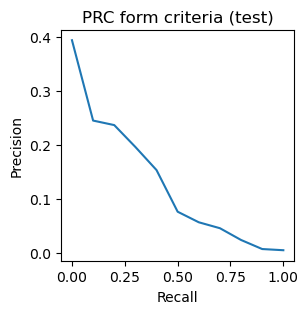

In [177]:
fig, ax = plt.subplots(figsize=(3, 3))
plt.plot(vsm_criteria_test.recall_11point,vsm_criteria_test.avg_precision_11point/len(test))
ax.set_title("PRC form criteria (test)")
ax.set_ylabel("Precision")
ax.set_xlabel("Recall")
plt.show()

In [178]:
#summary
tfidf_wm_summary_test = index.transform(brief_summary_docs)
vsm_summ_test = Vsm()
vsm_summ_test.fit(ids, tfidf_wm_summary_test, test)
vsm_summ_test.show_results()

Mean of p10:  0.1166666666666667 
Mean of recall:  1.0 
Mean of ap_p:  0.08959613213786033 
Mean of ndcg5_p:  0.10062240729640498 
Mean of mrr_p:  0.00459643316786174
0.4 1.0 0.42485902255639096 0.469909445244515 0.018753447324875896
0.0 1.0 0.001949317738791423 0.0 0.0002757859900717044


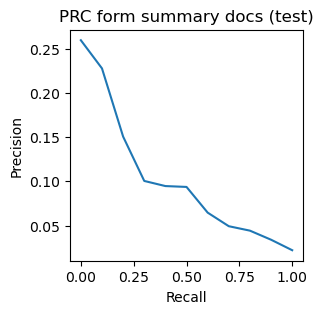

In [179]:
fig, ax = plt.subplots(figsize=(3, 3))
plt.plot(vsm_summ_test.recall_11point,vsm_summ_test.avg_precision_11point/len(test))
ax.set_title("PRC form summary docs (test)")
ax.set_ylabel("Precision")
ax.set_xlabel("Recall")
plt.show()

# Language Model with Jelinek-Mercer Smoothing

# Training LM

In [180]:
import pickle
docs = pickle.load( open( "documents.bin", "rb" ) )
ids = pickle.load( open( "doc_ids.bin", "rb" ) )
docs_detailed_desc = pickle.load(open("documents_detailed_description.bin", "rb"))
brief_summary_docs = pickle.load(open("brief_summary_docs.bin", "rb"))
criteria_docs = pickle.load(open("criteria_docs.bin", "rb"))

from sklearn.metrics.pairwise import pairwise_distances
from sklearn.feature_extraction.text import CountVectorizer

index = CountVectorizer(ngram_range=(1,1), analyzer='word', stop_words = None)

In [181]:
class Lmjm:
    def find_best_lambda(self, ids, X, data, index):
        lambdas = [0.01, 0.05, 0.1, 0.2, 0.5]
        p10_dict = dict()
        for lam in lambdas:
            self.fit(ids, X, data, index, lam)
            p10_dict[lam] = np.mean(self.p10_p)
        return max(p10_dict, key=p10_dict.get)
    
    
    def fit(self, ids, X, data, index, lam):
        self.Queries = "topics-2014_2015-summary.topics"
        self.Qrels = "qrels-clinical_trials.txt"
        self.eval = trec.TrecEvaluation(data, Qrels)
        self.avg_precision_11point = np.zeros(11)
        self.doc_scores = []
        self.p10_p = []
        self.recall_p = []
        self.ap_p = []
        self.ndcg5_p = []
        self.mrr_p = []
        self.l = lam
        self.score_set = []
        self.recall_11point = 0
        X_n = pd.DataFrame(X.toarray(), columns=index.get_feature_names_out())
        termfreq = X_n.sum()
        Mc = termfreq/termfreq.sum()
        Md = (X_n.T/X_n.T.sum()).T

        Md = Md.to_numpy()
        Mc = Mc.to_numpy()
        for caseid in data:
            query = data[caseid]
            query_tfidf = index.transform([query]).toarray()
            query_tfidf = np.ravel(query_tfidf)

            terms_non_zero = np.ravel(np.nonzero(query_tfidf))

            scores_docs = self.l * np.array(Md[:, terms_non_zero]) * query_tfidf[terms_non_zero]
            scores_Mc = (1-self.l) * (Mc[terms_non_zero])
            scores = (scores_docs + scores_Mc)

            doc_scores = np.sum(np.log(scores), axis = 1)

            results = pd.DataFrame(list(zip(ids, doc_scores)), columns = ['_id', 'score'])
            results_ord = results.sort_values(by=['score'], ascending = False) 

            [p10, recall, ap, ndcg5, mrr] = eval.eval(results_ord, caseid)
            [precision_11point, self.recall_11point, total_relv_ret] = eval.evalPR(results_ord, caseid)
            if (np.shape(self.recall_11point) != (0,)):
                self.avg_precision_11point = self.avg_precision_11point + precision_11point

            self.p10_p.append(p10)
            self.recall_p.append(recall)
            self.ap_p.append(ap)
            self.ndcg5_p.append(ndcg5)
            self.mrr_p.append(mrr)
            
            for i, j in results.to_numpy():
                self.score_set.append((caseid, i, j))
            
    def show_results(self):
        print ("Mean of p10: ", np.mean(self.p10_p),"\nMean of recall: ", np.mean(self.recall_p), "\nMean of ap_p: ", np.mean(self.ap_p), "\nMean of ndcg5_p: ", np.mean(self.ndcg5_p),"\nMean of mrr_p: ", np.mean(self.mrr_p))
        print (max(self.p10_p), max(self.recall_p), max(self.ap_p), max(self.ndcg5_p), max(self.mrr_p))
        print (min(self.p10_p), min(self.recall_p), min(self.ap_p), min(self.ndcg5_p), min(self.mrr_p))

In [182]:
#docs
X_docs_LM_train = index.fit_transform(docs)
lmjm_docs_train = Lmjm()
best_lambda = lmjm_docs_train.find_best_lambda(ids, X_docs_LM_train, train, index)
print(best_lambda)
lmjm_docs_train.fit(ids, X_docs_LM_train, train, index, best_lambda)
lmjm_docs_train.show_results()

0.1
Mean of p10:  0.0625 
Mean of recall:  0.9791666666666666 
Mean of ap_p:  0.03695871369548858 
Mean of ndcg5_p:  0.047437028755951495 
Mean of mrr_p:  0.00520546056260342
0.5 1.0 0.33121283438882804 0.3391602052736161 0.017374517374517374
0.0 0 0 0.0 0


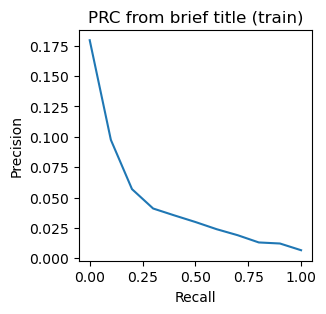

In [183]:
fig, ax = plt.subplots(figsize=(3, 3))
plt.plot(lmjm_docs_train.recall_11point,lmjm_docs_train.avg_precision_11point/len(train))
ax.set_title("PRC from brief title (train)")
ax.set_ylabel("Precision")
ax.set_xlabel("Recall")
plt.show()

In [184]:
#VSM docs detailed
X_detailed_LM_train = index.fit_transform(docs_detailed_desc)
LMJM_detailed_train = Lmjm()
best_lambda = lmjm_docs_train.find_best_lambda(ids, X_detailed_LM_train, train, index)
print(best_lambda)
LMJM_detailed_train.fit(ids, X_detailed_LM_train, train, index, best_lambda)
LMJM_detailed_train.show_results()

0.1
Mean of p10:  0.11041666666666666 
Mean of recall:  0.9791666666666666 
Mean of ap_p:  0.07845213596703364 
Mean of ndcg5_p:  0.11857671586159742 
Mean of mrr_p:  0.00520546056260342
0.6 1.0 0.4084466279589102 0.5551553341043619 0.017374517374517374
0.0 0 0 0.0 0


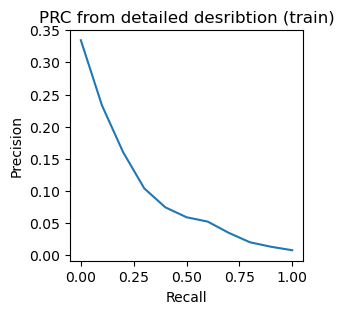

In [185]:
fig, ax = plt.subplots(figsize=(3, 3))
plt.plot(LMJM_detailed_train.recall_11point,LMJM_detailed_train.avg_precision_11point/len(train))
ax.set_title("PRC from detailed desribtion (train)")
ax.set_ylabel("Precision")
ax.set_xlabel("Recall")
plt.show()

In [186]:
#criteria
X_criteria_LM_train = index.fit_transform(criteria_docs)
LMJM_criteria_train = Lmjm()
best_lambda = lmjm_docs_train.find_best_lambda(ids, X_criteria_LM_train, train, index)
print(best_lambda)
LMJM_criteria_train.fit(ids, X_criteria_LM_train, train, index, best_lambda)
LMJM_criteria_train.show_results()

0.05
Mean of p10:  0.11874999999999998 
Mean of recall:  0.9791666666666666 
Mean of ap_p:  0.06717819491295589 
Mean of ndcg5_p:  0.11755209790902639 
Mean of mrr_p:  0.00520546056260342
0.6 1.0 0.2220077045460723 1.0 0.017374517374517374
0.0 0 0 0.0 0


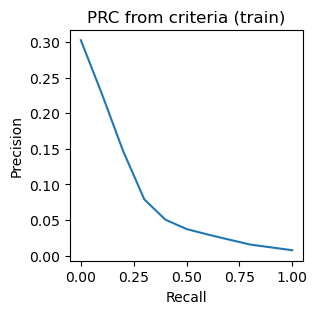

In [187]:
fig, ax = plt.subplots(figsize=(3, 3))
plt.plot(LMJM_criteria_train.recall_11point,LMJM_criteria_train.avg_precision_11point/len(train))
ax.set_title("PRC from criteria (train)")
ax.set_ylabel("Precision")
ax.set_xlabel("Recall")
plt.show()

In [188]:
#summary
X_summary_LM_train = index.fit_transform(brief_summary_docs)
LMJM_summary_train = Lmjm()
best_lambda = lmjm_docs_train.find_best_lambda(ids, X_summary_LM_train, train, index)
print(best_lambda)
LMJM_summary_train.fit(ids, X_summary_LM_train, train, index, best_lambda)
LMJM_summary_train.show_results()

0.2
Mean of p10:  0.0979166666666667 
Mean of recall:  0.9791666666666666 
Mean of ap_p:  0.06230247106814154 
Mean of ndcg5_p:  0.08211245574340158 
Mean of mrr_p:  0.00520546056260342
0.5 1.0 0.34115827605563454 0.44149241373678083 0.017374517374517374
0.0 0 0 0.0 0


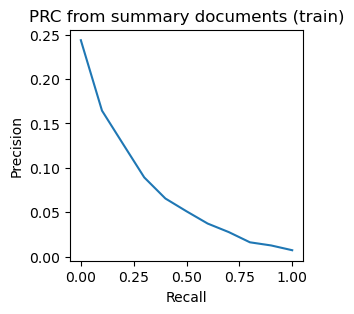

In [189]:
fig, ax = plt.subplots(figsize=(3, 3))
plt.plot(LMJM_summary_train.recall_11point,LMJM_summary_train.avg_precision_11point/len(train))
ax.set_title("PRC from summary documents (train)")
ax.set_ylabel("Precision")
ax.set_xlabel("Recall")
plt.show()

# Testing LM

In [190]:
#docs
X_docs_LM_test = index.transform(docs)
LMJM_docs_test = Lmjm()
LMJM_docs_test.fit(ids, X_docs_LM_test, test, index, 0.1)
LMJM_docs_test.show_results()

C:\Users\pawel\AppData\Local\Temp\ipykernel_10460\2007199252.py:43: RuntimeWarning: divide by zero encountered in log
  doc_scores = np.sum(np.log(scores), axis = 1)
C:\Users\pawel\AppData\Local\Temp\ipykernel_10460\2007199252.py:43: RuntimeWarning: divide by zero encountered in log
  doc_scores = np.sum(np.log(scores), axis = 1)
C:\Users\pawel\AppData\Local\Temp\ipykernel_10460\2007199252.py:43: RuntimeWarning: divide by zero encountered in log
  doc_scores = np.sum(np.log(scores), axis = 1)
C:\Users\pawel\AppData\Local\Temp\ipykernel_10460\2007199252.py:43: RuntimeWarning: divide by zero encountered in log
  doc_scores = np.sum(np.log(scores), axis = 1)
C:\Users\pawel\AppData\Local\Temp\ipykernel_10460\2007199252.py:43: RuntimeWarning: divide by zero encountered in log
  doc_scores = np.sum(np.log(scores), axis = 1)
C:\Users\pawel\AppData\Local\Temp\ipykernel_10460\2007199252.py:43: RuntimeWarning: divide by zero encountered in log
  doc_scores = np.sum(np.log(scores), axis = 1)
C:\U

Mean of p10:  0.008333333333333333 
Mean of recall:  1.0 
Mean of ap_p:  0.016192201199218815 
Mean of ndcg5_p:  0.017832188727877295 
Mean of mrr_p:  0.00459643316786174
0.1 1.0 0.061865195107868365 0.21398626473452756 0.018753447324875896
0.0 1.0 0.0013716102780669366 0.0 0.0002757859900717044


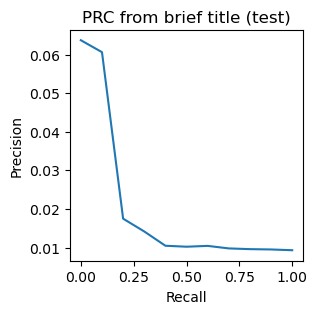

In [191]:
fig, ax = plt.subplots(figsize=(3, 3))
plt.plot(LMJM_docs_test.recall_11point,LMJM_docs_test.avg_precision_11point/len(test))
ax.set_title("PRC from brief title (test)")
ax.set_ylabel("Precision")
ax.set_xlabel("Recall")
plt.show()

In [192]:
#VSM docs detailed
X_detailed_LM_test = index.transform(docs_detailed_desc)
LMJM_detailed_test = Lmjm()
LMJM_detailed_test.fit(ids, X_detailed_LM_test, test, index, 0.1)
LMJM_detailed_test.show_results()

Mean of p10:  0.16666666666666666 
Mean of recall:  1.0 
Mean of ap_p:  0.0999243641198207 
Mean of ndcg5_p:  0.12173658806810171 
Mean of mrr_p:  0.00459643316786174
0.5 1.0 0.3436126257810016 0.3536181454553091 0.018753447324875896
0.0 1.0 0.002864991331473462 0.0 0.0002757859900717044


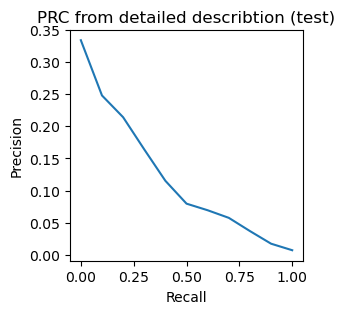

In [193]:
fig, ax = plt.subplots(figsize=(3, 3))
plt.plot(LMJM_detailed_test.recall_11point,LMJM_detailed_test.avg_precision_11point/len(test))
ax.set_title("PRC from detailed describtion (test)")
ax.set_ylabel("Precision")
ax.set_xlabel("Recall")
plt.show()

In [194]:
#criteria
X_criteria_LM_test = index.transform(criteria_docs)
LMJM_criteria_test = Lmjm()
LMJM_criteria_test.fit(ids, X_criteria_LM_test, test, index, 0.05)
LMJM_criteria_test.show_results()

C:\Users\pawel\AppData\Local\Temp\ipykernel_10460\2007199252.py:43: RuntimeWarning: divide by zero encountered in log
  doc_scores = np.sum(np.log(scores), axis = 1)
C:\Users\pawel\AppData\Local\Temp\ipykernel_10460\2007199252.py:43: RuntimeWarning: divide by zero encountered in log
  doc_scores = np.sum(np.log(scores), axis = 1)
C:\Users\pawel\AppData\Local\Temp\ipykernel_10460\2007199252.py:43: RuntimeWarning: divide by zero encountered in log
  doc_scores = np.sum(np.log(scores), axis = 1)
C:\Users\pawel\AppData\Local\Temp\ipykernel_10460\2007199252.py:43: RuntimeWarning: divide by zero encountered in log
  doc_scores = np.sum(np.log(scores), axis = 1)


Mean of p10:  0.075 
Mean of recall:  1.0 
Mean of ap_p:  0.06819050790594179 
Mean of ndcg5_p:  0.13995180628070833 
Mean of mrr_p:  0.00459643316786174
0.4 1.0 0.4049263707836379 0.6702844482938307 0.018753447324875896
0.0 1.0 0.0013716102780669366 0.0 0.0002757859900717044


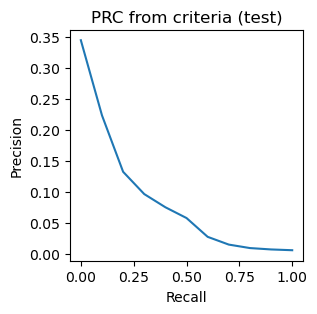

In [195]:
fig, ax = plt.subplots(figsize=(3, 3))
plt.plot(LMJM_criteria_test.recall_11point,LMJM_criteria_test.avg_precision_11point/len(test))
ax.set_title("PRC from criteria (test)")
ax.set_ylabel("Precision")
ax.set_xlabel("Recall")
plt.show()

In [196]:
#summary
X_summary_LM_test = index.transform(brief_summary_docs)
LMJM_summary_test = Lmjm()
LMJM_summary_test.fit(ids, X_summary_LM_test, test, index, 0.2)
LMJM_summary_test.show_results()

Mean of p10:  0.1416666666666667 
Mean of recall:  1.0 
Mean of ap_p:  0.10601660405558842 
Mean of ndcg5_p:  0.1086580615567579 
Mean of mrr_p:  0.00459643316786174
0.6 1.0 0.6327733009961926 0.5941231586290995 0.018753447324875896
0.0 1.0 0.0018248175182481751 0.0 0.0002757859900717044


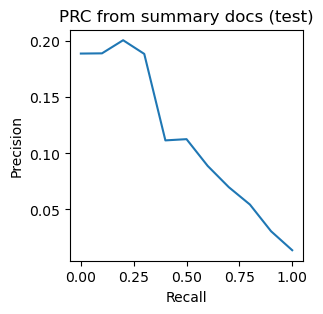

In [198]:
fig, ax = plt.subplots(figsize=(3, 3))
plt.plot(LMJM_summary_test.recall_11point,LMJM_summary_test.avg_precision_11point/len(test))
ax.set_title("PRC from summary docs (test)")
ax.set_ylabel("Precision")
ax.set_xlabel("Recall")
plt.show()

# Table of all

## Training

In [42]:
from sklearn.preprocessing import normalize


column_names = ["query_id", "doc_id", "vsm_brief_title"]
features_table = vsm_docs_train.score_set.copy()
features_table = pd.DataFrame(features_table, columns = column_names)
features_table["vsm_detailed_description"] = [el[2] for el in vsm_detail_train.score_set]
features_table["vsm_criteria"] = [el[2] for el in vsm_criteria_train.score_set]
features_table["vsm_summary"] = [el[2] for el in vsm_summ_train.score_set]
features_table["lmjm_brief_title"] = [el[2] for el in lmjm_docs_train.score_set]
features_table["lmjm_detailed_description"] = [el[2] for el in LMJM_detailed_train.score_set]
features_table["lmjm_criteria"] = [el[2] for el in LMJM_criteria_train.score_set]
features_table["lmjm_summary"] = [el[2] for el in LMJM_summary_train.score_set]


features_table.head(-5)

,query_id,doc_id,vsm_brief_title,vsm_detailed_description,vsm_criteria,vsm_summary,lmjm_brief_title,lmjm_detailed_description,lmjm_criteria,lmjm_summary
0,20152,NCT00000369,0.010067,0.008425,0.015404,0.024422,-121.138871,-131.736696,-111.567678,-116.869304
1,20152,NCT00000402,0.023260,0.025572,0.010257,0.024081,-121.744096,-130.151783,-111.599060,-117.427501
2,20152,NCT00000408,0.000000,0.022244,0.032098,0.035608,-120.164684,-131.434995,-110.986755,-116.393264
3,20152,NCT00000430,0.014018,0.019210,0.039978,0.013142,-123.663144,-131.470853,-111.405534,-118.621110
4,20152,NCT00000432,0.000000,0.010973,0.002901,0.008192,-124.490557,-131.816158,-111.588117,-118.951240
...,...,...,...,...,...,...,...,...,...,...
174038,201511,NCT02632656,0.022706,0.027685,0.013165,0.018392,-223.070698,-213.431789,-212.067095,-213.672990
174039,201511,NCT02633033,0.004208,0.018913,0.053529,0.018522,-222.731488,-213.162096,-210.530897,-213.414242
174040,201511,NCT02633163,0.008606,0.026146,0.032473,0.018172,-223.073447,-213.607476,-211.897534,-213.892553
174041,201511,NCT02633254,0.018286,0.034174,0.019813,0.023672,-220.130967,-212.745152,-211.792843,-212.054366


### Normalization

In [43]:
from sklearn import preprocessing

min_max_scaler = preprocessing.MinMaxScaler()
features_table.iloc[:,-8:] = min_max_scaler.fit_transform(features_table.iloc[:,-8:])

### labels

In [44]:
column_names_qrl = ["id", "smth", "doc_id", "label"]
qrls = pd.read_csv(Qrels, sep="\t", header = None)

labels = dict()
c = 0
for i in qrls[2]:
    j = qrls.iloc[c,3]
    if (j != 0):
        j = 1
    labels[i] = j
    c += 1

features_table["label"] = features_table["doc_id"].map(labels)

features_table.head(10)

,query_id,doc_id,vsm_brief_title,vsm_detailed_description,vsm_criteria,vsm_summary,lmjm_brief_title,lmjm_detailed_description,lmjm_criteria,lmjm_summary,label
0,20152,NCT00000369,0.022862,0.024582,0.039909,0.068292,0.784217,0.772070,0.833552,0.791043,1
1,20152,NCT00000402,0.052821,0.074610,0.026576,0.067339,0.782138,0.777565,0.833437,0.788986,0
2,20152,NCT00000408,0.000000,0.064899,0.083163,0.099574,0.787564,0.773116,0.835670,0.792797,0
3,20152,NCT00000430,0.031833,0.056049,0.103579,0.036750,0.775547,0.772992,0.834143,0.784589,0
4,20152,NCT00000432,0.000000,0.032014,0.007517,0.022908,0.772705,0.771795,0.833477,0.783373,0
5,20152,NCT00000492,0.000000,0.051262,0.022725,0.020935,0.773087,0.772109,0.832754,0.783508,1
6,20152,NCT00000499,0.018112,0.050303,0.018111,0.044917,0.775586,0.772158,0.832304,0.784637,1
7,20152,NCT00000501,0.000000,0.071018,0.022001,0.042819,0.777316,0.774949,0.832350,0.785416,0
8,20152,NCT00000506,0.025266,0.048943,0.014780,0.044999,0.780001,0.772406,0.832334,0.786790,0
9,20152,NCT00000520,0.021847,0.061748,0.011744,0.031250,0.778298,0.774510,0.832129,0.786584,1


### Gender

In [45]:
import re

def get_gender(query):
    result_men = re.search("\s(m[ae]n|males?|boys?)[\s\,.!?]", query)
    result_women = re.search("wom[ae]n|females?|girls?|in menopause", query)
    if result_men:
        return 0
    if result_women:
        return 1
    else:
        return 2

    
gender = dict()
for key in train:
    gender[key] = get_gender(train[key])

features_table["gender"] = features_table["query_id"].map(gender)

features_table.tail()

,query_id,doc_id,vsm_brief_title,vsm_detailed_description,vsm_criteria,vsm_summary,lmjm_brief_title,lmjm_detailed_description,lmjm_criteria,lmjm_summary,label,gender
174043,201511,NCT02633449,0.000000,0.053120,0.023891,0.035652,0.430964,0.487571,0.466778,0.433814,1,1
174044,201511,NCT02633735,0.000000,0.116194,0.025043,0.071997,0.434038,0.488747,0.467280,0.433706,1,1
174045,201511,NCT02633787,0.013970,0.039867,0.053352,0.018187,0.426811,0.487442,0.466695,0.430727,0,1
174046,201511,NCT02634138,0.046172,0.193557,0.158965,0.034223,0.429696,0.498271,0.473270,0.432366,1,1
174047,201511,NCT02634190,0.076485,0.055863,0.041316,0.048171,0.431967,0.489901,0.467050,0.433345,0,1


## Testing

In [109]:
from sklearn.preprocessing import normalize


column_names = ["query_id", "doc_id", "vsm_brief_title"]
features_table_test = vsm_docs_test.score_set.copy()
features_table_test = pd.DataFrame(features_table_test, columns = column_names)
features_table_test["vsm_detailed_description"] = [el[2] for el in vsm_detail_test.score_set]
features_table_test["vsm_criteria"] = [el[2] for el in vsm_criteria_test.score_set]
features_table_test["vsm_summary"] = [el[2] for el in vsm_summ_test.score_set]
features_table_test["lmjm_brief_title"] = [el[2] for el in LMJM_docs_test.score_set]
features_table_test["lmjm_detailed_description"] = [el[2] for el in LMJM_detailed_test.score_set]
features_table_test["lmjm_criteria"] = [el[2] for el in LMJM_criteria_test.score_set]
features_table_test["lmjm_summary"] = [el[2] for el in LMJM_summary_test.score_set]

features_table_test["lmjm_brief_title"] = features_table_test["lmjm_brief_title"].replace(-np.inf, 0)
features_table_test["lmjm_criteria"] = features_table_test["lmjm_criteria"].replace(-np.inf, 0)
features_table_test["lmjm_detailed_description"] = features_table_test["lmjm_detailed_description"].replace(to_replace=np.nan, value=0)

features_table_test.head(-5)

,query_id,doc_id,vsm_brief_title,vsm_detailed_description,vsm_criteria,vsm_summary,lmjm_brief_title,lmjm_detailed_description,lmjm_criteria,lmjm_summary
0,20159,NCT00000369,0.000000,0.008335,0.013068,0.029652,0.0,-131.005825,-119.355894,-130.959338
1,20159,NCT00000402,0.005169,0.031476,0.001892,0.021283,0.0,-129.360386,-119.646288,-131.980801
2,20159,NCT00000408,0.000000,0.028021,0.037211,0.038571,0.0,-130.525406,-118.761954,-130.572460
3,20159,NCT00000430,0.004878,0.032490,0.079195,0.009415,0.0,-130.384973,-118.627322,-133.198664
4,20159,NCT00000432,0.000000,0.025759,0.000000,0.008991,0.0,-130.240263,-119.745823,-133.292703
...,...,...,...,...,...,...,...,...,...,...
43502,20157,NCT02632656,0.009378,0.033052,0.032505,0.031158,0.0,-169.333716,-173.761674,-171.014216
43503,20157,NCT02633033,0.002653,0.017667,0.071370,0.017667,0.0,-169.853285,-173.512897,-172.595898
43504,20157,NCT02633163,0.005517,0.028713,0.066173,0.016216,0.0,-170.087821,-172.974316,-173.340153
43505,20157,NCT02633254,0.006098,0.023831,0.014111,0.013642,0.0,-170.199306,-174.020148,-173.162706


### Normalization

In [110]:
from sklearn import preprocessing

min_max_scaler = preprocessing.MinMaxScaler()
features_table_test.iloc[:,-8:] = min_max_scaler.fit_transform(features_table_test.iloc[:,-8:])

### Labels

In [111]:
column_names_qrl = ["id", "smth", "doc_id", "label"]
qrls = pd.read_csv(Qrels, sep="\t", header = None)

labels = dict()
c = 0
for i in qrls[2]:
    j = qrls.iloc[c,3]
    if (j != 0):
        j = 1
    labels[i] = j
    c += 1

features_table_test["label"] = features_table_test["doc_id"].map(labels)

features_table_test.head(10)

,query_id,doc_id,vsm_brief_title,vsm_detailed_description,vsm_criteria,vsm_summary,lmjm_brief_title,lmjm_detailed_description,lmjm_criteria,lmjm_summary,label
0,20159,NCT00000369,0.000000,0.032708,0.042584,0.106999,1.0,0.467308,0.488523,0.805811,1
1,20159,NCT00000402,0.012231,0.123512,0.006166,0.076799,1.0,0.473999,0.487279,0.798872,0
2,20159,NCT00000408,0.000000,0.109956,0.121260,0.139181,1.0,0.469262,0.491068,0.808440,0
3,20159,NCT00000430,0.011542,0.127492,0.258076,0.033974,1.0,0.469833,0.491645,0.790598,0
4,20159,NCT00000432,0.000000,0.101079,0.000000,0.032443,1.0,0.470421,0.486852,0.789959,0
5,20159,NCT00000492,0.000000,0.104798,0.013670,0.038381,1.0,0.469398,0.488022,0.790926,1
6,20159,NCT00000499,0.000000,0.100884,0.018567,0.067452,1.0,0.468683,0.487795,0.792750,1
7,20159,NCT00000501,0.000000,0.144765,0.021239,0.069106,1.0,0.471396,0.487741,0.794632,0
8,20159,NCT00000506,0.013387,0.075653,0.017702,0.073472,1.0,0.467703,0.487844,0.797687,0
9,20159,NCT00000520,0.009686,0.162171,0.014387,0.040283,1.0,0.476108,0.487505,0.795154,1


### Gender

In [112]:
import re

def get_gender(query):
    result_men = re.search("\s(m[ae]n|males?|boys?)[\s\,.!?]", query)
    result_women = re.search("wom[ae]n|females?|girls?|in menopause", query)
    if result_men:
        return 0
    if result_women:
        return 1
    else:
        return 2

    
gender = dict()
for key in test:
    gender[key] = get_gender(test[key])

features_table_test["gender"] = features_table_test["query_id"].map(gender)

features_table_test.head()

,query_id,doc_id,vsm_brief_title,vsm_detailed_description,vsm_criteria,vsm_summary,lmjm_brief_title,lmjm_detailed_description,lmjm_criteria,lmjm_summary,label,gender
0,20159,NCT00000369,0.000000,0.032708,0.042584,0.106999,1.0,0.467308,0.488523,0.805811,1,2
1,20159,NCT00000402,0.012231,0.123512,0.006166,0.076799,1.0,0.473999,0.487279,0.798872,0,2
2,20159,NCT00000408,0.000000,0.109956,0.121260,0.139181,1.0,0.469262,0.491068,0.808440,0,2
3,20159,NCT00000430,0.011542,0.127492,0.258076,0.033974,1.0,0.469833,0.491645,0.790598,0,2
4,20159,NCT00000432,0.000000,0.101079,0.000000,0.032443,1.0,0.470421,0.486852,0.789959,0,2


# LETOR

## Training

In [216]:
y_train = features_table["label"]
X_train = features_table.drop(["query_id", "label", "doc_id"], axis=1)

X_train_numpy = X_train.to_numpy()
y_train_numpy = y_train.to_numpy()

In [118]:
#Finding best C
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, precision_score, precision_recall_curve

parameters = {'C':[0.1, 0.5, 1, 2, 5]}
precision = []
clf2 = LogisticRegression(random_state=42, class_weight = "balanced", max_iter= 500)
cv2 = GridSearchCV(clf2, parameters, cv=5)
cv2.fit(X_train, y_train)
C = cv2.best_params_
predict = cv2.predict(X_train)
precision.append(precision_score(y_train, predict))
print(precision)
print(classification_report(predict, y_train))

[0.30533250367912135]
              precision    recall  f1-score   support

         0.0       0.44      0.74      0.55     72801
         1.0       0.62      0.31      0.41    101247

    accuracy                           0.49    174048
   macro avg       0.53      0.53      0.48    174048
weighted avg       0.55      0.49      0.47    174048



## Cross-validation

In [123]:
#Cross-validation with best C
precisin_train_all = []
precisin_val_all = []
skf = StratifiedKFold(n_splits=5, shuffle=True)
for train_index, validation_index in skf.split(X_train, y_train):
    X_train_k, X_validation_k = X_train_numpy[train_index], X_train_numpy[validation_index]
    y_train_k, y_validation_k = y_train_numpy[train_index], y_train_numpy[validation_index]
    clf = LogisticRegression(random_state=42, class_weight = "balanced", C = C["C"], max_iter= 500).fit(X_train_k, y_train_k)
    predict_train = clf.predict(X_train_k)
    predict_val = clf.predict(X_validation_k)
    precisin_train_all.append(precision_score(y_train_k, predict_train))
    precisin_val_all.append(precision_score(y_validation_k, predict_val))
    
print(np.mean(precisin_train_all))
print(np.mean(precisin_val_all))
print(classification_report(predict_train, y_train_k))

0.3056903916669212
0.30527572171271855
              precision    recall  f1-score   support

         0.0       0.44      0.75      0.55     58307
         1.0       0.63      0.31      0.41     80932

    accuracy                           0.49    139239
   macro avg       0.53      0.53      0.48    139239
weighted avg       0.55      0.49      0.47    139239



In [140]:
#Without class_weight
precision_train = []
clf3 = LogisticRegression(random_state=42, max_iter= 500, C = C["C"]).fit(X_train, y_train)
predict = clf3.predict(X_train)
y_score = clf3.predict_proba(X_train)[:,1]
precision_train.append(precision_score(y_train, predict))
print(precision_train)
print(classification_report(predict, y_train))

C:\Users\pawel\anaconda3\envs\myenvIR\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\pawel\anaconda3\envs\myenvIR\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.0]
              precision    recall  f1-score   support

         0.0       1.00      0.72      0.83    174048
         1.0       0.00      0.00      0.00         0

    accuracy                           0.72    174048
   macro avg       0.50      0.36      0.42    174048
weighted avg       1.00      0.72      0.83    174048



C:\Users\pawel\anaconda3\envs\myenvIR\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\pawel\anaconda3\envs\myenvIR\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [204]:
#Balanced
precision_train = []
clf3 = LogisticRegression(random_state=42, class_weight = "balanced", max_iter= 500, C = C["C"]).fit(X_train, y_train)
predict = clf3.predict(X_train)
y_score = clf3.predict_proba(X_train)[:,1]
precision_train.append(precision_score(y_train, predict))
print(precision_train)
print(classification_report(predict, y_train))

[0.30533250367912135]
              precision    recall  f1-score   support

         0.0       0.44      0.74      0.55     72801
         1.0       0.62      0.31      0.41    101247

    accuracy                           0.49    174048
   macro avg       0.53      0.53      0.48    174048
weighted avg       0.55      0.49      0.47    174048



In [206]:
#OWN class_weights
precision_train = []
clf3 = LogisticRegression(random_state=42, class_weight = { 0:0.33, 1:0.67 }, max_iter= 500, C = C["C"]).fit(X_train, y_train)
predict = clf3.predict(X_train)
y_score = clf3.predict_proba(X_train)[:,1]
precision_train.append(precision_score(y_train, predict))
print(precision_train)
print(classification_report(predict, y_train))

[0.38288288288288286]
              precision    recall  f1-score   support

         0.0       1.00      0.72      0.83    173826
         1.0       0.00      0.38      0.00       222

    accuracy                           0.72    174048
   macro avg       0.50      0.55      0.42    174048
weighted avg       1.00      0.72      0.83    174048



In [234]:
#COEF
df = pd.DataFrame(np.exp(clf3.coef_.T), X_train.columns,
                  columns=['coef'])\
            .sort_values(by='coef', ascending=False)
print(df)

                               coef
lmjm_summary               5.273503
lmjm_criteria              1.471705
vsm_detailed_description   1.134824
vsm_summary                1.058672
gender                     0.999279
vsm_brief_title            0.924437
lmjm_detailed_description  0.865362
lmjm_brief_title           0.130059
vsm_criteria               0.088544


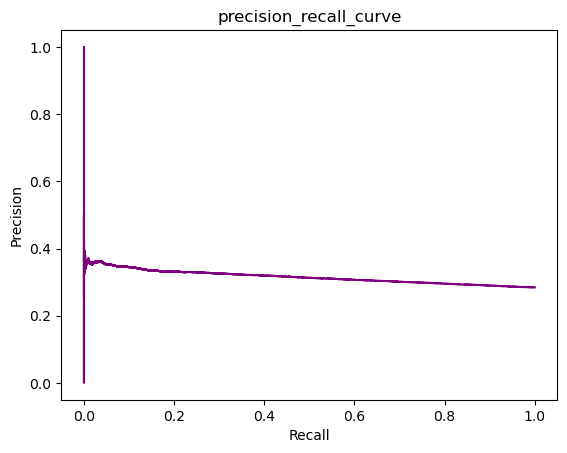

In [207]:
import matplotlib.pyplot as plt
precision, recall, tresholds = precision_recall_curve(y_train, y_score)

fig, ax = plt.subplots()
ax.plot(recall, precision, color = 'purple')
ax.set_title("precision_recall_curve")
ax.set_ylabel("Precision")
ax.set_xlabel("Recall")
plt.show()

## Testing

In [121]:
y_test = features_table_test["label"]
X_test = features_table_test.drop(["query_id", "label", "doc_id"], axis=1)

X_test_numpy = X_test.to_numpy()
y_test_numpy = y_test.to_numpy()

In [145]:
#Finding best C
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, precision_score, precision_recall_curve

precision_test = []
predict_test = clf3.predict(X_test)
precision_test.append(precision_score(y_test, predict_test))
print(precision_test)
print(classification_report(predict_test, y_test))

[0.2848459732007183]
              precision    recall  f1-score   support

         0.0       0.83      0.72      0.77     36273
         1.0       0.17      0.28      0.21      7239

    accuracy                           0.64     43512
   macro avg       0.50      0.50      0.49     43512
weighted avg       0.72      0.64      0.68     43512

